In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.utils import plot_model


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding,Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [2]:
msg_df = pd.read_csv("review.csv")
msg_df = msg_df[['text' , 'stars']]
msg_df
# msg_df = msg_df[0:500]

,text,stars
0,"Great interiors, great service, a well-thought...",3
1,This place was the first BIG mall I ever went ...,3
2,The brisket wasn't very tender and the sausage...,3
3,After hearing and seeing so many photos I thou...,3
4,"The food came out really fast, but was not the...",3
...,...,...
9995,"Terrible service, lady that helped us was rude...",2
9996,The place is beautiful. They did an excellent ...,2
9997,Bad service but good food. I've been here man...,2
9998,"I'm sad to say, my last few visits here have b...",2


In [3]:
msg_df['stars'].value_counts()

3    2000
5    2000
4    2000
1    2000
2    2000
Name: stars, dtype: int64

In [4]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

In [5]:
msg_df['stars'] = msg_df.stars.apply(map_sentiment_scores)
msg_df.head(5)

,text,stars
0,"Great interiors, great service, a well-thought...",2
1,This place was the first BIG mall I ever went ...,2
2,The brisket wasn't very tender and the sausage...,2
3,After hearing and seeing so many photos I thou...,2
4,"The food came out really fast, but was not the...",2


In [6]:
msg_label = msg_df['stars'].values

In [31]:
msg_label

array([2, 2, 2, ..., 1, 1, 1])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(msg_df['text'], msg_label, test_size=0.2, random_state=434)

In [8]:
x_train

5481    I first went here early this year with my boyf...
9897    This place needs to close for a day and do a t...
4860    Came to the Kaye clinic today for a breathing ...
7489    Holy frozen cheeseburger for $17 AND the chees...
2152    RJ is fast and awesome! in and out in under 5 ...
                              ...                        
6341    Food is good. Service is horrible. If you're l...
5697    Nice location.  Good venue.  Decent food.  Goo...
9541    I'll preface this review by saying we should h...
5554    i stopped in Tina's on a whim to get a full se...
1809    Great pizza. They always get my order right an...
Name: text, Length: 8000, dtype: object

In [9]:
y_train

array([3, 1, 3, ..., 1, 3, 2])

In [10]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes=5)

In [33]:
y_train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [11]:
max_len = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 15000

In [12]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [13]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words


23896

In [14]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [15]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [16]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (8000, 500)
Shape of testing tensor:  (2000, 500)


#BiLSTM

In [21]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
embedding_dim = 786

model = Sequential()
model.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model.add(Dropout(drop_lstm))
model.add(Dense(5, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 786)          11790000  
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               936960    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 12728245 (48.55 MB)
Trainable params: 12728245 (48.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


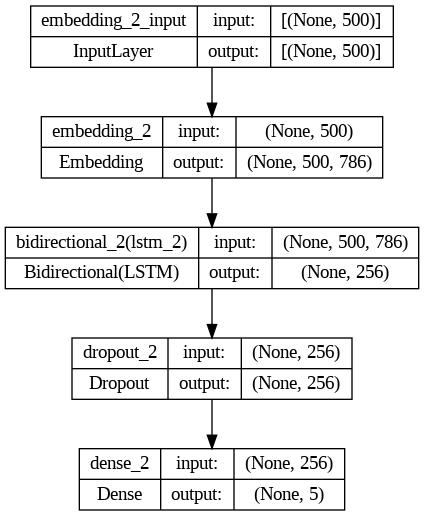

In [23]:
plot_model(model, to_file='bilstm_model.png', show_shapes=True, show_layer_names=True)


In [24]:
model.compile(loss = 'sparse_categorical_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [25]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
250/250 - 63s - loss: 1.3297 - accuracy: 0.4140 - val_loss: 1.2604 - val_accuracy: 0.4450 - 63s/epoch - 252ms/step
Epoch 2/30
250/250 - 37s - loss: 0.9716 - accuracy: 0.5906 - val_loss: 1.1565 - val_accuracy: 0.5025 - 37s/epoch - 148ms/step
Epoch 3/30
250/250 - 28s - loss: 0.7133 - accuracy: 0.7138 - val_loss: 1.3300 - val_accuracy: 0.4715 - 28s/epoch - 113ms/step
Epoch 4/30
250/250 - 29s - loss: 0.5213 - accuracy: 0.8036 - val_loss: 1.5076 - val_accuracy: 0.4905 - 29s/epoch - 115ms/step


In [26]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

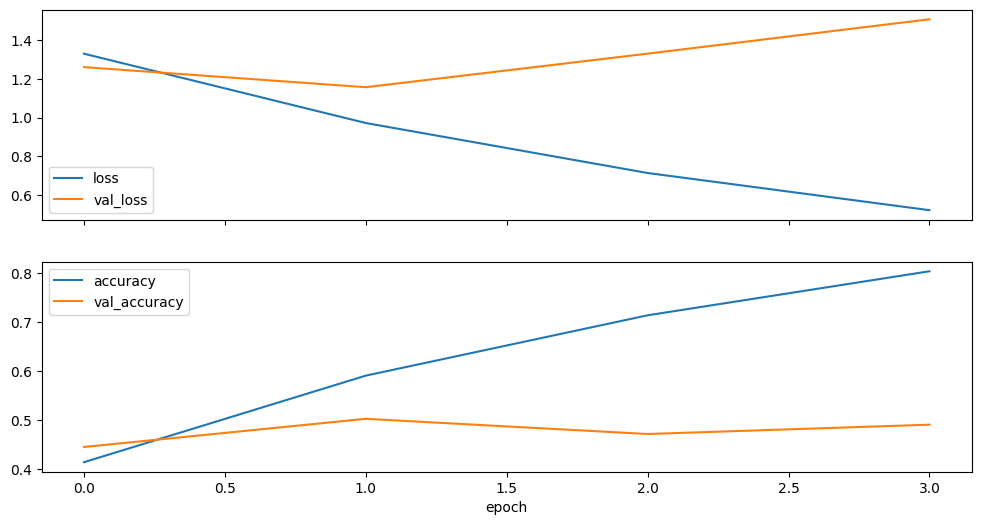

In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

63/63 [==============================] - 2s 28ms/step


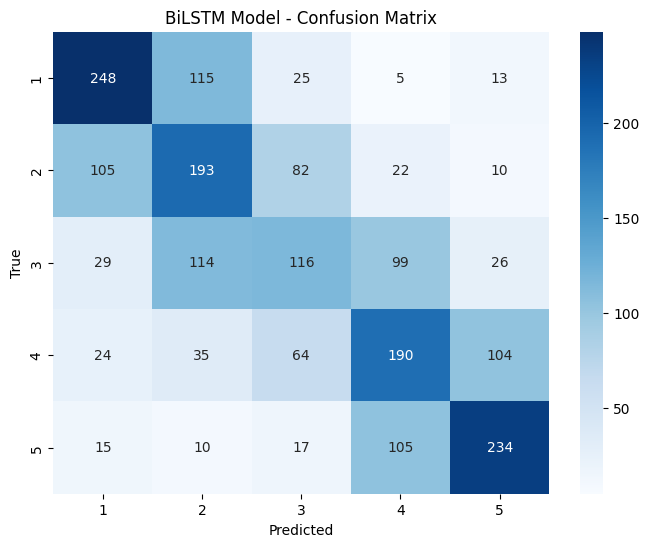

In [30]:
# Predict probabilities for the test set using BiLSTM model
y_pred_probs_bilstm = model.predict(testing_padded)

# Convert probabilities to class predictions
y_pred_bilstm = np.argmax(y_pred_probs_bilstm, axis=1)

# Create a confusion matrix
conf_matrix_bilstm = confusion_matrix(y_test, y_pred_bilstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bilstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.title('BiLSTM Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [34]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(testing_padded, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


63/63 [==============================] - 2s 34ms/step - loss: 1.5076 - accuracy: 0.4905
Test Accuracy: 49.05%


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(testing_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test to one-hot encoding for compatibility with model.predict
y_test_one_hot = to_categorical(y_test, num_classes=5)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))


63/63 [==============================] - 2s 30ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       406
           1       0.41      0.47      0.44       412
           2       0.38      0.30      0.34       384
           3       0.45      0.46      0.45       417
           4       0.60      0.61      0.61       381

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [35]:
# Function to preprocess new review text
def preprocess_text(text, tokenizer, max_len):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    return padded_sequence

# New review text
new_text = "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."

# Preprocess the text
preprocessed_text = preprocess_text(new_text, tokenizer, max_len)

# Predict the star rating
predicted_star = model.predict(preprocessed_text)

# Decoding the predicted rating
predicted_star_rating = np.argmax(predicted_star, axis=1)
print("Predicted Star Rating:", predicted_star_rating[0] + 1)


1/1 [==============================] - 0s 34ms/step
Predicted Star Rating: 2
